# Blood Transfusion Classifier

## Supervised, Semi-Supervised, and Unsupervised Learning


a) Download the Blood Transfusion Service Center Data Set from: https://archive. ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center. This data has two output classes.Use the ﬁrst 20% of the positive and negative classes in the ﬁle as the test set and the rest as the training set. 

In [112]:
import pandas as pd
import numpy as np
import seaborn as sb
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.svm import LinearSVC,SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,auc
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors

In [28]:
df=pd.read_csv("transfusion.data")

*As we can see from the snippet below, the data has same feature values for different classes. Hence, we should expect to get skewed prediction *

In [29]:
df[580:590]

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
580,2,1,250,2,0
581,2,1,250,2,1
582,2,1,250,2,0
583,2,1,250,2,0
584,2,1,250,2,0
585,2,1,250,2,0
586,2,1,250,2,1
587,2,1,250,2,0
588,2,1,250,2,0
589,2,1,250,2,0


In [30]:
df.columns.values[-1]='DidDonate'

In [31]:
df=df.rename({})

<Figure size 4800x4800 with 0 Axes>

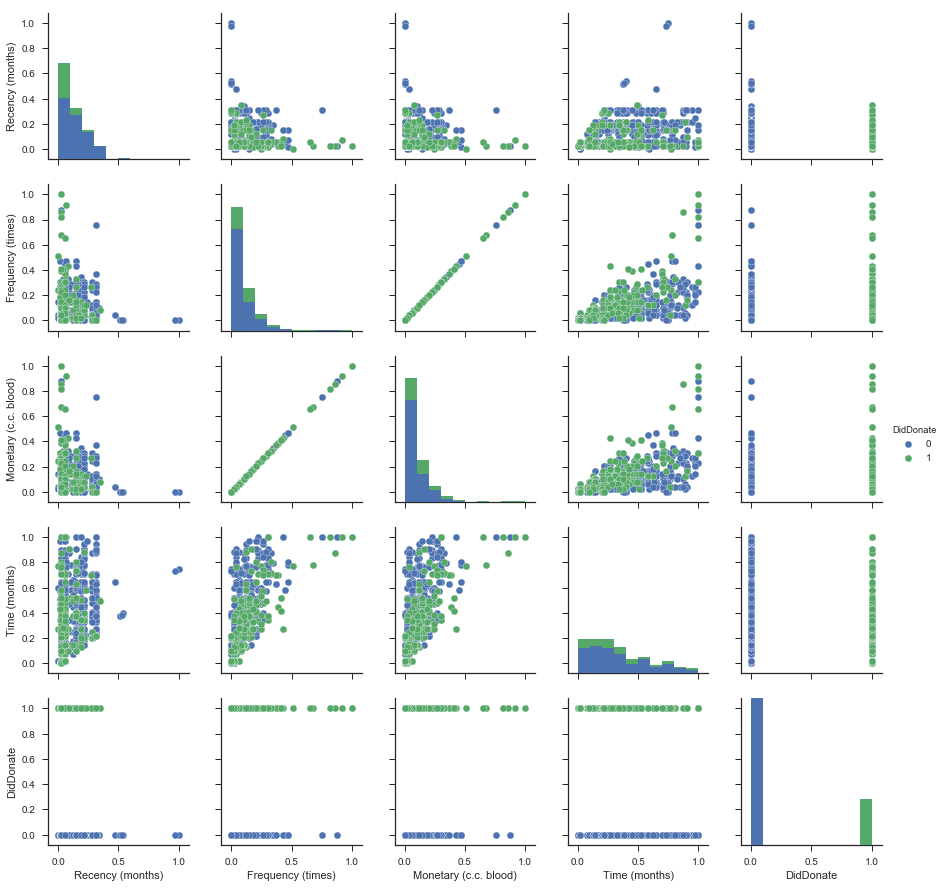

In [140]:
plt.figure(num=None, figsize=(60,60), dpi=80, facecolor='w', edgecolor='k')
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df,hue='DidDonate')
plt.show()

In [32]:
#df.drop_duplicates(subset=df.columns.values[:-1],inplace=True,keep='first')

In [33]:
#mdf=RemoveOutliers(df)

In [34]:
#Considers Last column as label
#Remove 3 standard Deviations

def RemoveOutliers(kdf):
    pdf=kdf.copy()
    scaler = StandardScaler()
    pdf[pdf.columns[:-1]] = scaler.fit_transform(pdf[pdf.columns[:-1]])
    for i in pdf.columns[:-1]:
        pdf[i] = np.where((pdf[i]>3) | (pdf[i]<-3),np.NaN,pdf[i])
    pdf.dropna(axis=0,inplace=True)
    return pdf;

In [35]:
df.describe()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),DidDonate
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


### Normalize

In [36]:
scaler = MinMaxScaler()
df[df.columns[:-1]] = scaler.fit_transform(df[df.columns[:-1]])

In [37]:
test=df.query('DidDonate == 0').head(n=int(np.ceil(df.query('DidDonate == 0').shape[0]*0.2)))
test=test.append(df.query('DidDonate == 1').head(n=int(np.ceil(df.query('DidDonate == 1').shape[0]*0.2))))

In [38]:
train=df.drop(test.index)

In [39]:
train.describe()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),DidDonate
count,598.000000,598.000000,598.000000,598.000000,598.000000
mean,0.150321,0.081189,0.081189,0.347809,0.237458
std,0.111203,0.109423,0.109423,0.248860,0.425882
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.054054,0.020408,0.020408,0.145833,0.000000
50%,0.148649,0.040816,0.040816,0.281250,0.000000
75%,0.216216,0.102041,0.102041,0.500000,0.000000
max,1.000000,0.877551,0.877551,1.000000,1.000000


In [40]:
test.describe()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),DidDonate
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.041351,0.135782,0.135782,0.290278,0.240000
std,0.029921,0.144307,0.144307,0.269163,0.428514
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.027027,0.040816,0.040816,0.093750,0.000000
50%,0.027027,0.102041,0.102041,0.244792,0.000000
75%,0.054054,0.204082,0.204082,0.458333,0.000000
max,0.175676,1.000000,1.000000,1.000000,1.000000


(b) **Supervised Learning**: Train an L1-penalized SVM to classify the data. Use 5 fold cross validation to choose the penalty parameter. Use normalized data. Report the accuracy, AUC, ROC, and confusion matrix for both training and test sets. 

In [129]:
param_grid={'C': np.logspace(-2, 10, 13)};
cv = KFold(5)
grid_search = GridSearchCV(LinearSVC( penalty='l1', dual=False), param_grid, cv=cv,n_jobs=4)

In [130]:
grid_search.fit(train[train.columns[:-1]],train[train.columns[-1]])

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [131]:
grid_search.best_params_

{'C': 1.0}

In [132]:
cclf=CalibratedClassifierCV(base_estimator=grid_search, cv='prefit')
cclf.fit(train[train.columns[:-1]],train[train.columns[-1]])

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', ra...     pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0),
            cv='prefit', method='sigmoid')

In [133]:
y_pred=grid_search.predict(test[test.columns[:-1]])

In [135]:
cclf.score(test[test.columns[:-1]],test.DidDonate)

0.7866666666666666

In [305]:
y_proba=cclf.predict_proba(test[test.columns[:-1]])[:,1]

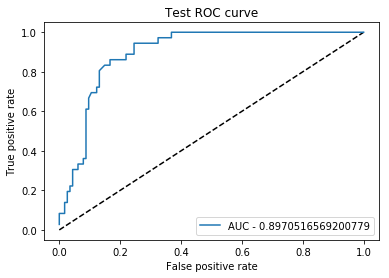

In [668]:
fpr_rf, tpr_rf, _ = roc_curve(np.array(y_test), y_proba,pos_label=1)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label="AUC - "+str(auc(fpr_rf,tpr_rf)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Test ROC curve')
plt.legend(loc='best')
plt.show()

In [306]:
roc_auc_score(test.DidDonate,y_pred)

0.6783625730994152

In [356]:
y_test=test.DidDonate
y_train=train.DidDonate

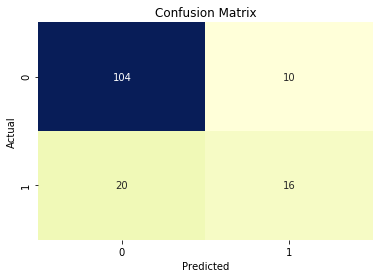

In [355]:
cm=confusion_matrix(test.DidDonate,y_pred)
sns.heatmap(cm, annot=True,cbar=False,cmap="YlGnBu",fmt="d", )
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [357]:
y_proba_t=cclf.predict_proba(train[train.columns[:-1]])[:,1]

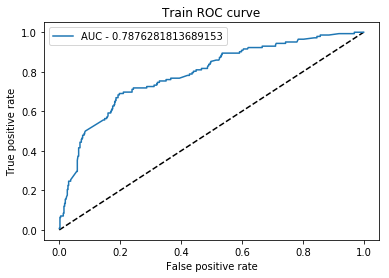

In [366]:
fpr_rf, tpr_rf, _ = roc_curve(np.array(y_train), y_proba_t,pos_label=1)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label="AUC - "+str(auc(fpr_rf,tpr_rf)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Train ROC curve')
plt.legend(loc='best')
plt.show()

In [251]:
grid_search.score(train[train.columns[:-1]],train.DidDonate)

0.7725752508361204

In [254]:
y_pred_T=grid_search.predict(train[train.columns[:-1]])

In [255]:
roc_auc_score(train.DidDonate,y_pred_T)

0.5380992092908328

In [352]:
cm=confusion_matrix(train.DidDonate,y_pred_T)

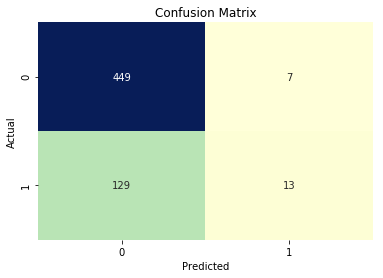

In [354]:
sns.heatmap(cm, annot=True,cbar=False,cmap="YlGnBu",fmt="d", )
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

(c) **Semi-Supervised Learning/ Self-training**: select 50% of the positive class along with 50% of the negative class in the training set as labeled data and the rest as unlabelled data. You can select them randomly.

In [645]:
train.DidDonate.value_counts()

0    456
1    142
Name: DidDonate, dtype: int64

In [828]:
Labeled=train.query('DidDonate == 0').sample(frac=0.5)
Labeled=Labeled.append(train.query('DidDonate == 1').sample(frac=0.5))

In [829]:
Labeled.DidDonate.value_counts()

0    228
1     71
Name: DidDonate, dtype: int64

In [830]:
Unlabeled=train.drop(Labeled.index)

In [831]:
Unlabeled.DidDonate.value_counts()

0    228
1     71
Name: DidDonate, dtype: int64

 i. Train an L1-penalized SVM to classify the labeled data. Choose the penalty parameter using 5 fold cross validation. 

In [832]:
grid_search_l = GridSearchCV(LinearSVC( penalty='l1', dual=False), param_grid, cv=cv,n_jobs=4)
grid_search_l.fit(Labeled[Labeled.columns[:-1]],Labeled[Labeled.columns[-1]])

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [833]:
grid_search_l.best_params_

{'C': 0.01}

ii. Find the unlabeled data point that is the farthest to the decision boundary of the SVM. Let the SVM label it (ignore its true label), and add it to the labeled data, and retrain the SVM. Continue this process until all unlabeled data are used. Test the ﬁnal SVM on the test data and report the accuracy, AUC, ROC, and confusion matrix for the test set. 

In [834]:
while(Unlabeled.shape[0]!=0):
    clf=LinearSVC( penalty='l1', dual=False)
    clf.fit(Labeled[Labeled.columns[:-1]],Labeled.DidDonate)
    distanceList=[]
    distanceList=abs(clf.decision_function(Unlabeled[Unlabeled.columns[:-1]].values))
    index=sorted(range(len(distanceList)), key=lambda i: distanceList[i])[-1]
    toAdd=pd.DataFrame(Unlabeled.iloc[index]).T
    toAdd.DidDonate=clf.predict(Unlabeled.iloc[index][Unlabeled.columns[:-1]].reshape(1, -1))[0]
    Labeled=Labeled.append(toAdd)
    Unlabeled=Unlabeled.drop(Unlabeled.index[index])

C:\Users\tanay\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [835]:
Unlabeled.shape

(0, 5)

In [836]:
Labeled.shape

(598, 5)

In [837]:
clf.fit(Labeled[Labeled.columns[:-1]],Labeled.DidDonate)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)

In [838]:
y_pred_s=clf.predict(test[test.columns[:-1]])

In [839]:
clf.score(train[test.columns[:-1]],train.DidDonate)

0.7709030100334449

In [ ]:
cclf_s=CalibratedClassifierCV(base_estimator=clf, cv='prefit')
cclf_s.fit(Labeled[Labeled.columns[:-1]],Labeled.DidDonate)
y_proba_s=cclf_s.predict_proba(test[test.columns[:-1]])[:,1]

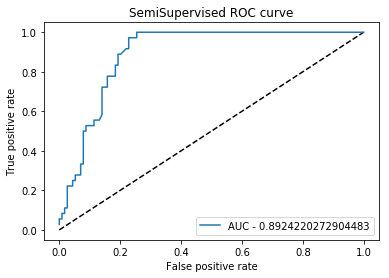

In [841]:
fpr_rf, tpr_rf, _ = roc_curve(np.array(y_test), y_proba_s,pos_label=1)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label="AUC - "+str(auc(fpr_rf,tpr_rf)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('SemiSupervised ROC curve')
plt.legend(loc='best')
plt.show()

In [842]:
roc_auc_score(test.DidDonate,y_pred_s)

0.5423976608187135

In [843]:
cm=confusion_matrix(test.DidDonate,y_pred_s)

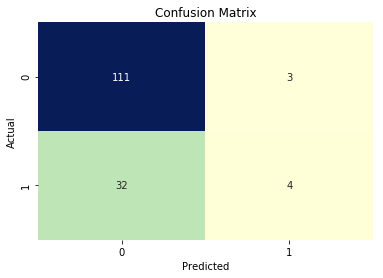

In [844]:
sns.heatmap(cm, annot=True,cbar=False,cmap="YlGnBu",fmt="d", )
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

(d) **Unsupervised Learning**: Run k-means algorithm on the whole training set. Ignore the labels of the data, and assume k = 2. 

i. Run the k-means algorithm multiple times. How do you make sure that the algorithm was not trapped in a local minimum?

Given enough time, K-means will always converge, however this may be to a local minimum. This is highly dependent on the initialization of the centroids. As a result, the computation is often done several times, with different initializations of the centroids. One method to help address this issue is the k-means++ initialization scheme, which has been implemented in scikit-learn (use the init='k-means++' parameter). This initializes the centroids to be (generally) distant from each other, leading to provably better results than random initialization.

In [80]:
kmeans = KMeans(n_clusters=2,n_init=100).fit(train[train.columns[:-1]])


In [81]:
kmeans.labels_

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,

ii. Compute the centers of the two clusters and ﬁnd the closest 30 data points to each center. Read the true labels of those 30 data points and take a majority poll within them. The majority poll becomes the label predicted by k-means for the members of each cluster. Then compare the labels provided by kmeans with the true labels of the training data and report accuracy and the confusion matrix.1 

In [82]:
kmeans.cluster_centers_

array([[0.15591471, 0.16541893, 0.16541893, 0.6419598 ],
       [0.14753099, 0.03917958, 0.03917958, 0.20110171]])

In [83]:
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(train[train.columns[:-1]],kmeans.labels_)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=2, p=2, radius=1.0)

In [93]:
kn=30

In [94]:
clus1=neigh.kneighbors(kmeans.cluster_centers_[:1],kn)[1][0]
clus2=neigh.kneighbors(kmeans.cluster_centers_[1:],kn)[1][0]

iii. Classify test data based on their proximity to the centers of the clusters. Report accuracy and confusion matrix for the test data. 

In [95]:
train.iloc[clus1].DidDonate.value_counts()

0    24
1     6
Name: DidDonate, dtype: int64

In [96]:
train.iloc[clus2].DidDonate.value_counts()

0    22
1     8
Name: DidDonate, dtype: int64

We observe that both clusters are dominated by one class **0**.  Therefore, we set label for both as 0.

In [145]:
y_pred=kmeans.predict(test[test.columns[:-1]])

In [150]:
y_pred=y_pred*0

In [149]:
roc_auc_score(test.DidDonate,y_pred)

0.5

In [146]:
accuracy_score(test.DidDonate,y_pred)

0.76

In [147]:
cm=confusion_matrix(test.DidDonate,y_pred)

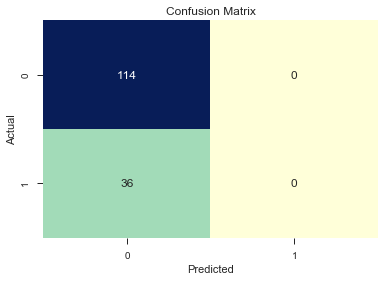

In [148]:
sns.heatmap(cm, annot=True,cbar=False,cmap="YlGnBu",fmt="d", )
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

(e) Extra Practice: The more principled way of doing the above steps is to run a Monte-Carlo simulation: Repeat the supervised, unsupervised, and semi-supervised learning procedures 50 or 100 times, for randomly selected train and test data(make sure you use 20% of both the positve and negative classes, because this is an imbalanced data set). Then compare the average accuracies that you obtain from each algorithm.

*1 Here we are using k-means as a classiﬁer. The closest 30 data points to each center are labeled by experts, so as to use k-means for classiﬁcation. Obviously, this is a na¨ıve approach.*

 (f) One expects that supervised learning on the full data set works better than semisupervised learning with half of the data set labeled.One expects that unsupervised learning underperforms in such situations. Compare the results you obtained by those methods.


### Conclusion

#### Due to the uneven divide in the dataset we obtain a very bad AUC scores for all methods.
1. Supervised
    * Test
        * Accuracy - 0.7866666666666666
        * AUC Score - 0.6783625730994152
    * Train
        * Accuracy - 0.7725752508361204
        * AUC Score - 0.5380992092908328
2. Semi-Supervised
    * Test
        * Accuracy - 0.7709030100334449
        * AUC Score - 0.5423976608187135
3. Unsupervised
    * Test
        * Accuracy - 0.76
        * AUC Score - 0.5

#### It is clear from the above results that Supervised method has a better test accuracy and AUC. Unsupervised method on the other hand misclassified  all of class **1**
       
       